## Setup
This notebook requires some packages besides pytorch-lightning.

In [1]:
! pip install --quiet "pandas" "torch" "torchvision" "ipython[notebook]" "seaborn" "pytorch-lightning" "torchmetrics" "lightning-bolts"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.8/722.8 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.6/731.6 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.8/300.8 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.5/829.5 kB 26.7 MB/s eta 0:00:00


In [2]:
import os

import pandas as pd
import seaborn as sn
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from IPython.core.display import display
from pl_bolts.datamodules import CIFAR10DataModule
from pl_bolts.transforms.dataset_normalizations import cifar10_normalization
from pytorch_lightning import LightningModule, Trainer, seed_everything
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import CSVLogger
from torch.optim.lr_scheduler import OneCycleLR
from torch.optim.swa_utils import AveragedModel, update_bn
from torchmetrics.functional import accuracy
from torchvision import datasets, transforms
import torch
import torchvision
import torch.nn.functional as F
import torchvision
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import numpy as np

PATH_DATASETS = os.environ.get("PATH_DATASETS", ".")
BATCH_SIZE = 512 if torch.cuda.is_available() else 64
NUM_WORKERS = int(os.cpu_count() / 2)

/usr/local/lib/python3.10/dist-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/usr/local/lib/python3.10/dist-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:92: UnderReviewWarning: The feature FeatureMapContrastiveTask is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  contrastive_task: Union[FeatureMapContrastiveTask] = FeatureMapCon

In [9]:
!git clone https://github.com/JaiBhagat/ERA1_main_repo-main.git

Cloning into 'ERA1_main_repo'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 47 (delta 13), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (47/47), 18.58 KiB | 3.10 MiB/s, done.
Resolving deltas: 100% (13/13), done.


In [10]:
from ERA1_main_repo import main, utils
from ERA1_main_repo.utils import *
from ERA1_main_repo.main import *

100%|██████████| 170498071/170498071 [00:05<00:00, 29387778.85it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


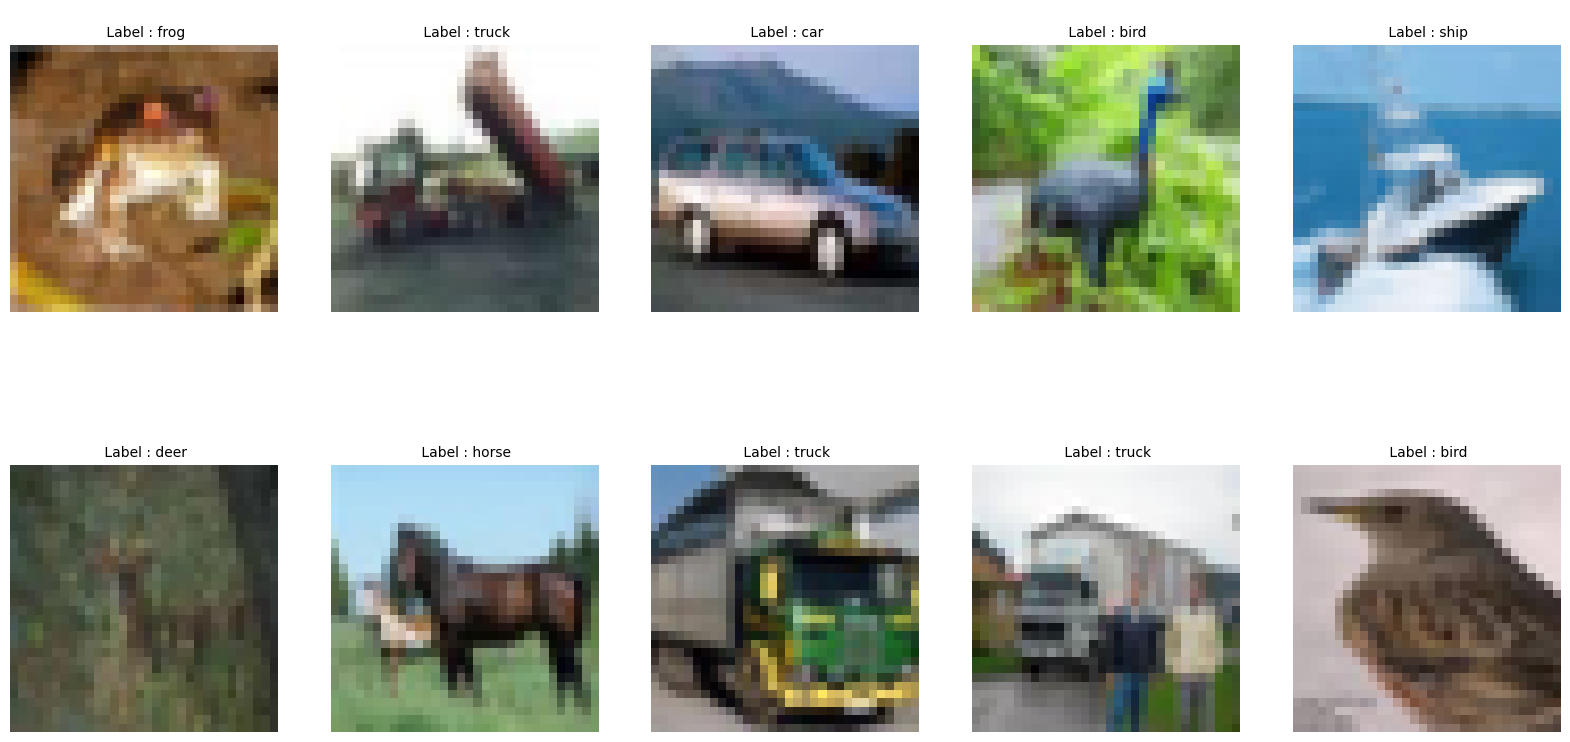

In [11]:
trainset_mod, trainloader_mod, testset_mod, testloader_mod = process_dataset( batch_size=512 )

### CIFAR10 Data Module

Import the existing data module from `bolts` and modify the train and test transforms.

In [12]:
# import module
import torch

# To get the layers and losses for our model
from torch import nn
import pytorch_lightning as pl

# To get the activation function for our model
import torch.nn.functional as F

# To get MNIST data and transforms
from torchvision import datasets, transforms

# To get the optimizer for our model
from torch.optim import SGD

# To get random_split to split training
# data into training and validation data
# and DataLoader to create dataloaders for train,
# valid and test data to be returned
# by our data module
from torch.utils.data import random_split, DataLoader

class DataModuleCIFAR10(pl.LightningDataModule):
    def __init__(self):
        super().__init__()

        # Directory to store MNIST Data
        self.download_dir = './data'

        # Defining batch size of our data
        self.batch_size = 512

        # Defining transforms to be applied on the data
        self.transform = transforms.Compose([
            transforms.ToTensor()
        ])

    def prepare_data(self):

          # Downloading our data
        datasets.CIFAR10(self.download_dir, train=True,
                                          download=True)

        datasets.CIFAR10(self.download_dir,
                       train = False, download = True)

    def setup(self, stage=None):

          # Loading our data after applying the transforms
        data = trainset_mod

        self.train_data, self.valid_data = random_split(data,
                                                        [45000, 5000])

        self.test_data = testset_mod

    def train_dataloader(self):

          # Generating train_dataloader
        return DataLoader(self.train_data,
                          batch_size = self.batch_size)

    def val_dataloader(self):

          # Generating val_dataloader
        return DataLoader(self.valid_data,
                          batch_size = self.batch_size)

    def test_dataloader(self):

        # Generating test_dataloader
        return DataLoader(self.test_data,
                          batch_size = self.batch_size)

In [13]:
cifar10_dm = DataModuleCIFAR10()

### Lightning Module
Check out the [`configure_optimizers`](https://pytorch-lightning.readthedocs.io/en/stable/common/lightning_module.html#configure-optimizers)
method to use custom Learning Rate schedulers. The OneCycleLR with SGD will get you to around 92-93% accuracy
in 20-30 epochs and 93-94% accuracy in 40-50 epochs. Feel free to experiment with different
LR schedules from https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate

In [14]:
class LitResnet(LightningModule):
    def __init__(self, lr=0.01, drop= 0.05, norm='BN',groupsize=1):
        super().__init__()

        self.save_hyperparameters()
        self.num_classes =10
        self.lr = lr

        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            self.user_norm(norm,64,groupsize),
            nn.Dropout(drop),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1, bias=False),
            nn.MaxPool2d(2,2),
            nn.ReLU(),
            self.user_norm(norm,128,groupsize),
            nn.Dropout(drop))
        self.res1 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            self.user_norm(norm,128,groupsize),
            nn.Dropout(drop),
            nn.Conv2d(in_channels = 128, out_channels=128, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            self.user_norm(norm,128,groupsize),
            nn.Dropout(drop)
             )

        # CONVOLUTION BLOCK 2
      	# Layer 2
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            self.user_norm(norm,256,groupsize),
            nn.Dropout(drop),
	        nn.MaxPool2d(2,2),
            nn.ReLU(),
            self.user_norm(norm,256,groupsize),
            nn.Dropout(drop)

             )

        # CONVOLUTION BLOCK 3
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3, 3), padding=1, bias=False),
	        nn.MaxPool2d(2,2),
            nn.ReLU(),
            self.user_norm(norm,512,groupsize),
            nn.Dropout(drop)
            )
        self.res2 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            self.user_norm(norm,512,groupsize),
            nn.Dropout(drop),
            nn.Conv2d(in_channels = 512, out_channels=512, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            self.user_norm(norm,512,groupsize),
            nn.Dropout(drop))

        # CONVOLUTION BLOCK 4
        self.convblock4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=4),
            nn.Conv2d(in_channels=512, out_channels=10, kernel_size=(1, 1), padding=0, bias=False))
        self.model = nn.Sequential(self.convblock1 ,self.convblock2, self.convblock3, self.convblock4)

    def user_norm(self, norm, channels,groupsize=1):
        if norm == 'BN':
            return nn.BatchNorm2d(channels)
        elif norm == 'LN':
            return nn.GroupNorm(1,channels) #(equivalent with LayerNorm)
        elif norm == 'GN':
            return nn.GroupNorm(groupsize,channels) #groups=2

    def forward(self, x):

        x = self.convblock1(x)
        x = x + self.res1 (x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = x + self.res2 (x)
        x = self.convblock4(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        self.log("train_loss", loss)
        return loss

    def evaluate(self, batch, stage=None):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y, task =  'multiclass', num_classes = self.num_classes)

        if stage:
            self.log(f"{stage}_loss", loss, prog_bar=True)
            self.log(f"{stage}_acc", acc, prog_bar=True)

    def validation_step(self, batch, batch_idx):
        self.evaluate(batch, "val")

    def test_step(self, batch, batch_idx):
        self.evaluate(batch, "test")

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(),
            lr=self.hparams.lr,
            weight_decay=5e-4,
        )

        steps_per_epoch = 50000 // BATCH_SIZE

        scheduler_dict = {
            "scheduler": OneCycleLR(
                optimizer,
                self.lr,
                epochs=self.trainer.max_epochs,
                steps_per_epoch=steps_per_epoch,
            ),
            "interval": "step",
        }
        return {"optimizer": optimizer, "lr_scheduler": scheduler_dict}

In [15]:
model = LitResnet(lr=0.01)

trainer = Trainer(
    max_epochs=24,
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None,  # limiting got iPython runs
    logger=CSVLogger(save_dir="logs/"),
    callbacks=[LearningRateMonitor(logging_interval="step"), TQDMProgressBar(refresh_rate=10)],
)

trainer.fit(model, cifar10_dm)
trainer.test(model, datamodule=cifar10_dm)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type       | Params
------------------------------------------
0 | convblock1 | Sequential | 75.8 K
1 | res1       | Sequential | 295 K 
2 | convblock2 | Sequential | 295 K 
3 | convblock3 | Sequential | 1.2 M 
4 | res2       | Sequential | 4.7 M 
5 | convblock4 | Sequential | 5.1 K 
6 | model      | Sequential | 1.6 M 
------------------------------------------
6.6 M     Trainable params
0         Non-trainable params
6.6 M     Total params
26.295    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=24` reached.


Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9180999994277954     │
│         test_loss         │    0.2433733344078064     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.2433733344078064, 'test_acc': 0.9180999994277954}]

,lr-Adam,train_loss,val_loss,val_acc,test_loss,test_acc
epoch,,,,,,
NaN,0.000516,NaN,NaN,NaN,NaN,NaN
0.0,NaN,1.361600,NaN,NaN,NaN,NaN
0.0,NaN,NaN,1.266148,0.5468,NaN,NaN
NaN,0.000869,NaN,NaN,NaN,NaN,NaN
1.0,NaN,1.134961,NaN,NaN,NaN,NaN


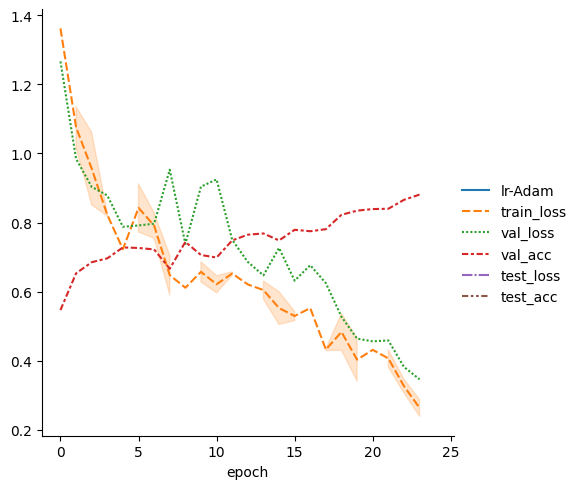

In [16]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
display(metrics.dropna(axis=1, how="all").head())
sn.relplot(data=metrics, kind="line")

In [17]:
torch.save(model.state_dict(), "model.pth")

In [18]:
!pip install --quiet git+https://github.com/jacobgil/pytorch-grad-cam.git


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [19]:
pip install --quiet gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 73.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.7/65.7 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 32.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.3/140.3 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 2.9 MB/s eta 0:

In [20]:
%load_ext gradio

# Getting Misclassified Images

In [21]:
from matplotlib import pyplot as plt
def get_incorrrect_predictions1(model, loader, device):
    """Get all incorrect predictions

    Args:
        model (Net): Trained model
        loader (DataLoader): instance of data loader
        device (str): Which device to use cuda/cpu

    Returns:
        list: list of all incorrect predictions and their corresponding details
    """
    model.eval()
    incorrect = []
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = F.cross_entropy(output, target)
            pred = output.argmax(dim=1)
            for image, target, pred in zip(data, target, pred):
                if pred.eq(target.view_as(pred)).item() == False:
                    incorrect.append([image.cpu(), target.cpu(), pred.cpu()])

    return incorrect

def display_incorrect_images1(mismatch, n=20 ):
    classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    display_images = mismatch[:n]
    index = 0
    fig = plt.figure(figsize=(10,5))
    for img in display_images:
        image = img[0].squeeze().to('cpu').numpy()
        pred = classes[img[2]]
        actual = classes[img[1]]
        ax = fig.add_subplot(2, 5, index+1)
        ax.axis('off')
        ax.set_title(f'\n Predicted Label : {pred} \n Actual Label : {actual}',fontsize=10)
        ax.imshow(np.transpose(image, (1, 2, 0)))
        index = index + 1
    plt.show()

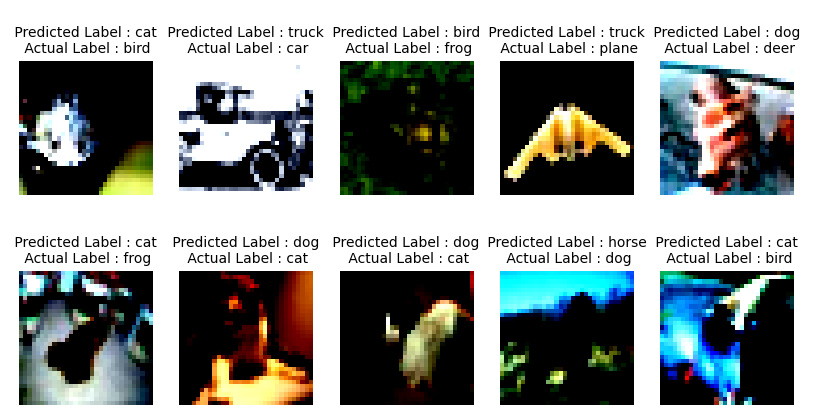

In [22]:
#model1 = model.to_device('cuda')
mis_class_images = get_incorrrect_predictions1(model, cifar10_dm.test_dataloader(), 'cpu')
display_incorrect_images1(mis_class_images, n=10)

# Gradio

In [25]:
import torch, torchvision
from torchvision import transforms
import numpy as np
import gradio as gr
from PIL import Image
from pytorch_grad_cam import GradCAM #, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
#from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
#from pytorch-gradcam.utils.image import show_cam_on_image
#from resnet import ResNet18
import gradio as gr

model = LitResnet(lr=0.005)
model.load_state_dict(torch.load("model.pth", map_location=torch.device('cpu')), strict=False)
#model = model.load_from_checkpoint(checkpoint_path="CIFAR10_custom_resnet_adam.ckpt")
inv_normalize = transforms.Normalize(
    mean=[-0.50/0.23, -0.50/0.23, -0.50/0.23],
    std=[1/0.23, 1/0.23, 1/0.23]
)
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')


def inference(input_img, wanna_see_gradcam, num_img_gradcam,
              wanna_see_misclassified,num_img_misclass,
              num_classes, transparency = 0.5, target_layer_number = -1):
    transform = transforms.ToTensor()
    org_img = input_img
    input_img = transform(input_img)
    input_img = input_img
    input_img = input_img.unsqueeze(0)
    outputs = model(input_img)
    softmax = torch.nn.Softmax(dim=0)
    o = softmax(outputs.flatten())
    confidences = {classes[i]: float(o[i]) for i in range(10)}
    _, prediction = torch.max(outputs, 1)
    if wanna_see_gradcam:
        target_layers = [model.convblock3[target_layer_number]]
        cam = GradCAM(model=model, target_layers=target_layers, use_cuda=False)
        grayscale_cam = cam(input_tensor=input_img, targets=None)
        grayscale_cam = grayscale_cam[0, :]
        img = input_img.squeeze(0)
        img = inv_normalize(img)
        rgb_img = np.transpose(img, (1, 2, 0))
        rgb_img = rgb_img.numpy()
        visualization = show_cam_on_image(org_img/255, grayscale_cam, use_rgb=True, image_weight=transparency)
    else:
        visualization = None
    return confidences, visualization

title = "CIFAR10 trained on Custom ResNet Model with GradCAM"
description = "A simple Gradio interface to infer on Custom ResNet model, and get GradCAM results"
examples = [["cat.jpg", 0.5, -1], ["dog.jpg", 0.5, -1]]
demo = gr.Interface(
    inference,
    inputs = [gr.Image(shape=(32, 32), label="Input Image"),
              gr.Checkbox(label = "Do you want to see GradCAM images?"),
              gr.Slider(0, 10, value=1, step=1, label="How Many GradCam images?"),
              gr.Checkbox(label = "Do you want to see misclassified images?"),
              gr.Slider(0, 10, value=1, step=1, label="How Many misclassified images?"),
              gr.Slider(0, 10, value=1, step=1, label="How Many top classes do you want to see?"),
              gr.Slider(0, 1, value = 0.5, label="Opacity of GradCAM"),
              gr.Slider(-2, -1, value = -2, step=1, label="Which Layer?")

              ],
    outputs = [gr.Label(num_top_classes = 4), gr.Image(shape=(32, 32), label="Output").style(width=128, height=128)],
    title = title,
    description = description,
    examples = examples,
)
demo.launch(share=True)

<ipython-input-25-09d32c2bc79f>:66: GradioDeprecationWarning: The `style` method is deprecated. Please set these arguments in the constructor instead.
  outputs = [gr.Label(num_top_classes = 4), gr.Image(shape=(32, 32), label="Output").style(width=128, height=128)],


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()


/usr/local/lib/python3.10/dist-packages/gradio/analytics.py:97: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if StrictVersion(latest_pkg_version) > StrictVersion(current_pkg_version):


Running on public URL: https://2a046ffbb3e87d00ee.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
